In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

data_frame = pd.read_csv('data.csv')
len(data_frame)
target_msrp = 'msrp'

In [63]:
data_frame.columns = data_frame.columns.str.lower().str.replace(' ', '_')

string_columns = list(data_frame.dtypes[data_frame.dtypes == 'object'].index)

for column in string_columns:
    data_frame[column] = data_frame[column].str.lower().str.replace(' ', '_')

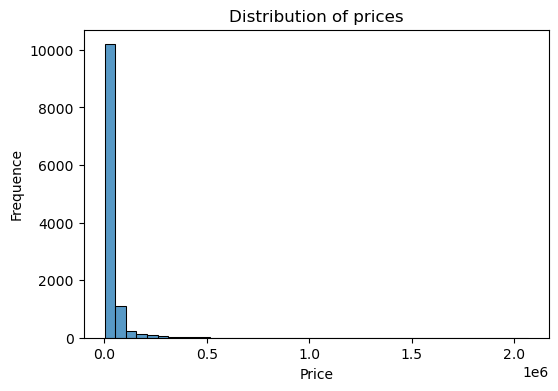

In [64]:
plt.figure(figsize=(6, 4))
sns.histplot(data_frame[target_msrp], bins=40)
plt.xlabel('Price')
plt.ylabel('Frequence')
plt.title('Distribution of prices')
plt.show()

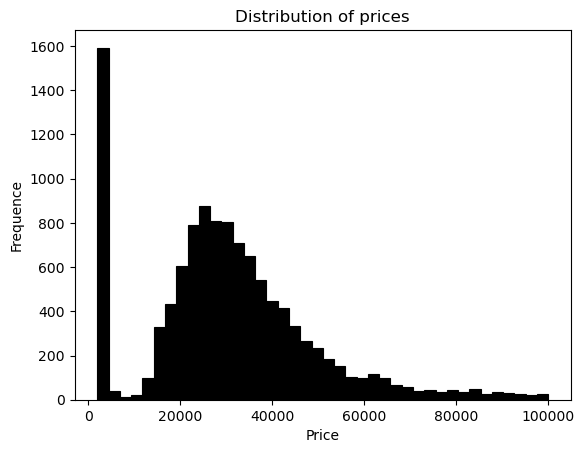

In [65]:
msrp_less_than_10000 = data_frame[target_msrp] < 100000

sns.histplot(data_frame.msrp[msrp_less_than_10000], bins=40, color='black', alpha=1)
plt.xlabel('Price')
plt.ylabel('Frequence')
plt.title('Distribution of prices')
plt.show()


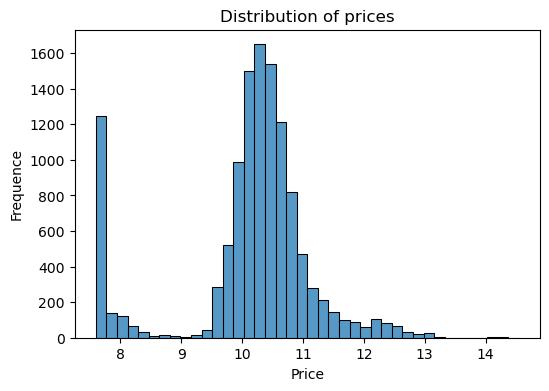

In [66]:
log_price = np.log1p(data_frame[target_msrp])
plt.figure(figsize=(6, 4))
sns.histplot(log_price, bins=40)
plt.xlabel('Price')
plt.ylabel('Frequence')
plt.title('Distribution of prices')
plt.show()

In [67]:
data_frame[target_msrp].isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
11909    False
11910    False
11911    False
11912    False
11913    False
Name: msrp, Length: 11914, dtype: bool

In [68]:
data_frame.head(5)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


In [71]:
data_frame['engine_fuel_type'].value_counts()

engine_fuel_type
regular_unleaded                                7172
premium_unleaded_(required)                     2009
premium_unleaded_(recommended)                  1523
flex-fuel_(unleaded/e85)                         899
diesel                                           154
electric                                          66
flex-fuel_(premium_unleaded_required/e85)         54
flex-fuel_(premium_unleaded_recommended/e85)      26
flex-fuel_(unleaded/natural_gas)                   6
natural_gas                                        2
Name: count, dtype: int64

### Validation Framework


In [7]:
number_of_data = len(data_frame)
number_of_validation = int(0.2 * number_of_data)
number_of_test = int(0.2 * number_of_data)
number_of_train = number_of_data - (number_of_validation + number_of_test)
index = np.arange(number_of_data)
np.random.seed(2)
np.random.shuffle(index)
df_shuffled = data_frame.iloc[index]

df_train = df_shuffled.iloc[:number_of_train].copy()
df_validation = df_shuffled.iloc[number_of_train:number_of_train + number_of_validation].copy()
df_test = df_shuffled.iloc[number_of_train + number_of_validation:].copy()


y_train = np.log1p(df_train[target_msrp].values)
y_validation = np.log1p(df_validation[target_msrp].values)
y_test = np.log1p(df_test[target_msrp].values)

del df_train[target_msrp]
del df_validation[target_msrp]
del df_test[target_msrp]

### Linear Regression

In [8]:
def train_linear_regression(X, y):
    rows_count_of_X = X.shape[0]
    ones = np.ones(rows_count_of_X)
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return (w[0], w[1:])

### Baseline Solution

In [109]:
def prepare_X(df):
    df_copied = df.copy()
    base = ['engine_hp','engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
    features = base.copy()

    age_feature = AgeFeature()
    age_feature.encode(df_copied, features)
    # add_age(df_copied, features)
    # column_year = df_copied['year']
    # max_year = column_year.max()
    # df_copied['age'] = max_year - column_year
    # features.append('age')

    add_doors(df_copied, features)
    add_makes(data_frame, df_copied, features)
    
    df_features = df_copied[features]
    df_features = df_features.fillna(0)
    X = df_features.values
    return X

In [110]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

In [111]:
y_prediction = w_0 + X_train.dot(w)

In [112]:
plt.figure(figsize=(6, 4))

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

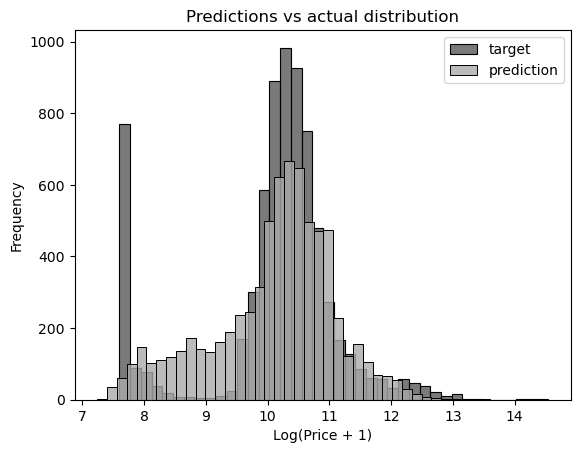

In [113]:
sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_prediction, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)
plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

In [114]:
def rmse(y, y_prediction):
    error = y_prediction - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [115]:
rmse(y_train, y_prediction)

0.5058876515487503

In [116]:
X_validation = prepare_X(df_validation)
y_validation_prediction = w_0 + X_validation.dot(w)

In [117]:
rmse(y_validation, y_validation_prediction)

0.5076038849557069

### Simple features engineering

In [105]:
class Feature:
    def __init__(self, origin_column, category, new_category_name):
        self.__origin_column = origin_column
        self.__category = category
        self.__new_category_name = new_category_name

    def encode(self, df, features):
        category = self.generate_category(df, features)
        for value in category:
            feature_key = self.generate_feature_key(value)
            df[feature_key] = self.generate_new_column(df, value)
            features.append(feature_key)

    
    def generate_category(self, df, features):
        return self.__category

    def generate_feature_key(self, value):
        return f'{self.__new_category_name}_{value}'

    def generate_new_column(self, df, value):
        return (df[self.__origin_column] == value).astype(int)
        

In [108]:
class AgeFeature(Feature):

    __key_age = 'age'

    def __init__(self):
        super().__init__(None, None, self.__class__.__key_age)

    def generate_category(self, df, features):
        return [self.__class__.__key_age]

    def generate_feature_key(self, value):
        return self.__class__.__key_age

    def generate_new_column(self, df, value):
        column_year = df['year']
        max_year = column_year.max()
        return max_year - column_year

In [30]:
def add_age(df, features):
    column_year = df['year']
    max_year = column_year.max()
    feature_key = 'age'
    df[key_age] = max_year - column_year
    features.append(feature_key)
    
    

In [50]:
def add_doors(df, features):
    key_num_of_doors = 'number_of_doors'
    for num_doors in [2, 3, 4]:
        feature_key = f'num_doors_{num_doors}'
        df[feature_key] = (df[key_num_of_doors] == num_doors).astype(int)
        features.append(feature_key)

In [ ]:
class MakeFeature(Feature):

     def __init__(self, origin_column, category, new_category_name):
        super.__init__(origin_column, category, new_category_name)

    

In [51]:
def add_makes(origin_df, df, features):
    key_make = 'make'
    top_five_make = origin_df[key_make].value_counts().head(5).index.tolist()
    for make in top_five_make:
        feature_key = f'is_make_{make}'
        df[feature_key] = (df[key_make] == make).astype(int)
        features.append(feature_key)



In [47]:
data_frame['make'].value_counts().head(5).index.tolist()

['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']